In [1]:
# import packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from scipy import stats
import scipy.optimize as optimize 

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Activation, Dense

df_ = pd.read_csv('perth_pro.csv',parse_dates=['DATE_SOLD'])
df_lstm = pd.concat([df_['PRICE'],df_['DATE_SOLD']],axis=1)
df_lstm.set_index(["DATE_SOLD"], inplace=True)
df_m = df_lstm.resample('m').mean()
df_m.head()

,PRICE
DATE_SOLD,
2018-01-31,700941.987310
2018-02-28,692248.801909
2018-03-31,664642.708911
2018-04-30,637053.050439
2018-05-31,656900.253385


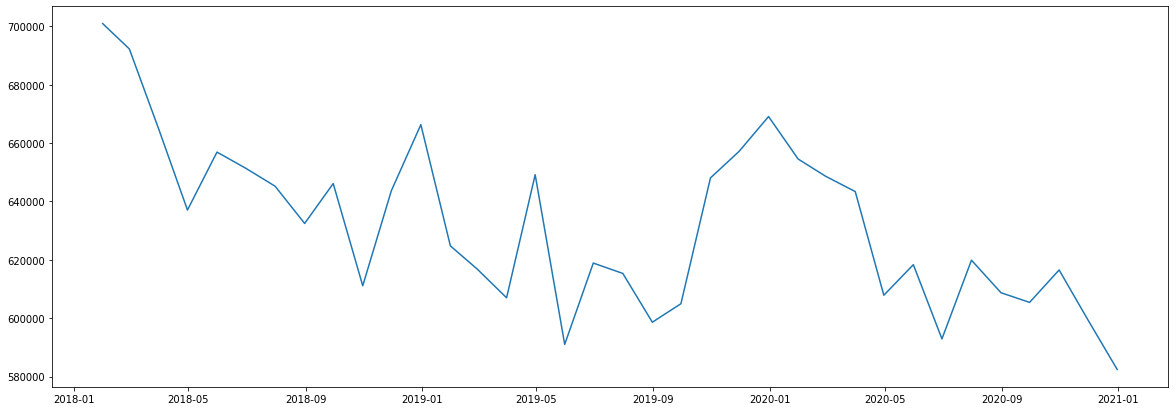

In [2]:
#plot the monthly mean price
plt.figure(figsize=(20,7))
plt.plot(df_m)

In [3]:
print(len(df_m))
df_m

36


,PRICE
DATE_SOLD,
2018-01-31,700941.987310
2018-02-28,692248.801909
2018-03-31,664642.708911
2018-04-30,637053.050439
2018-05-31,656900.253385
2018-06-30,651404.004566
2018-07-31,645214.037825
2018-08-31,632452.196653
2018-09-30,646116.926667


In [4]:
train_size = 25  # 25 month as train
train = df_m[:train_size] # set train set
test  = df_m[train_size:35] # set test set: 10
train_com = train.copy()
test_com = test.copy()
preX = df_m[33:35] # predict data: 1
preY = df_m[35:36]
pre_com = preY.copy()

In [5]:
# Normalization
to_normalize = ['PRICE']
mean_train = train_com[to_normalize].mean()
std_train = train_com[to_normalize].std()
mean_pre = preX[to_normalize].mean()


train[to_normalize] = (train[to_normalize]-mean_train)/std_train
test[to_normalize] = (test[to_normalize]-mean_train)/std_train


/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


dict_keys(['loss', 'val_loss'])


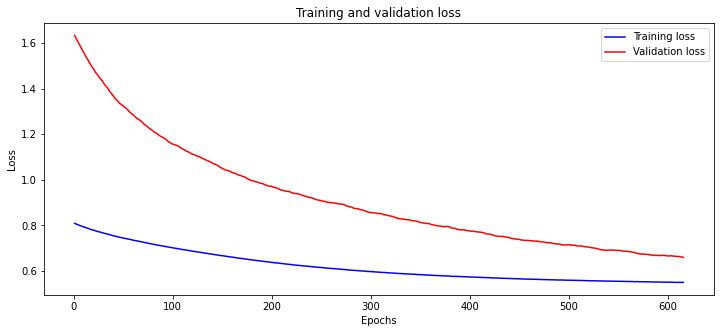

Train
The mean absolute error is: 18671.97
The mean squared error is: 432298775.03
The mean absolute percentage error is: 0.03
Test
The mean absolute error is: 20717.99
The mean squared error is: 518355120.57
The mean absolute percentage error is: 0.03
[[-0.45422727]]


In [6]:
#LSTM
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
# split the sequence to realize window slides. 
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# function to calculate mae mse and mape
def metrics_time_series(y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
    
    print(f"The mean absolute error is: {mae}")
    print(f"The mean squared error is: {mse}")
    print(f"The mean absolute percentage error is: {mape}")
    return mae, mse, mape

# define input sequence
raw_train = train.to_numpy()
raw_test = test.to_numpy()
# choose a number of time steps
n_steps = 2
# split into samples
trainX, trainY = split_sequence(raw_train, n_steps)
testX, testY = split_sequence(raw_test, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))
# define model
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
model = Sequential()
lr = 0.001
optimizer = tf.optimizers.SGD(learning_rate=lr)
l = 0.01
model.add(LSTM(4, input_shape=(n_steps, n_features)))
model.add(Dense(1,activity_regularizer=regularizers.l2(l)))
model.compile(optimizer=optimizer, loss='mse')

history=model.fit(trainX, trainY, epochs=2000, verbose=0, batch_size=3, callbacks=[es],validation_data=(testX, testY))
history_dict=history.history
history_dict.keys()
print(history_dict.keys())
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

plt.figure(figsize=(12,5))
# plot loss
plt.plot(epochs,loss_values,'b',label='Training loss')
plt.plot(epochs,val_loss_values,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

def scale_back(predictions):
    predictions = [prediction[0] for prediction in predictions] # unpack array

    # scale back
    mean_vol = train_com['PRICE'].mean()
    std_vol = train_com['PRICE'].std() 
    predictions = [prediction * std_vol + mean_vol for prediction in predictions]
    
    return predictions

# make prediction
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Predict
train_predict = scale_back(train_predict)
test_predict = scale_back(test_predict)
orgYtrain = scale_back(trainY)
orgYtest = scale_back(testY)

# print evaluation matrix
print("Train")
mae_train, mse_train,mape_train = metrics_time_series( orgYtrain, train_predict)
print("Test")
mae_test, mse_test, mape_train = metrics_time_series( orgYtest, test_predict)


# demonstrate prediction
x_input = preX.to_numpy()
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

dict_keys(['loss', 'val_loss'])


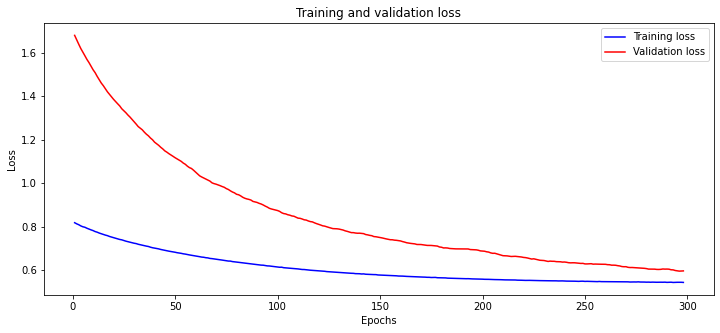

Train
The mean absolute error is: 18340.78
The mean squared error is: 426063269.24
The mean absolute percentage error is: 0.03
Test
The mean absolute error is: 18788.08
The mean squared error is: 467426581.55
The mean absolute percentage error is: 0.03
[[-0.58668786]]


In [7]:
# GRU
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
# split the sequence to realize window slides. 
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# function to calculate mae mse and mape
def metrics_time_series(y_true, y_pred):
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mse = round(mean_squared_error(y_true, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
    
    print(f"The mean absolute error is: {mae}")
    print(f"The mean squared error is: {mse}")
    print(f"The mean absolute percentage error is: {mape}")
    return mae, mse, mape

# define input sequence
raw_train = train.to_numpy()
raw_test = test.to_numpy()
# choose a number of time steps
n_steps = 2
# split into samples
trainX, trainY = split_sequence(raw_train, n_steps)
testX, testY = split_sequence(raw_test, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
testX = testX.reshape((testX.shape[0], testX.shape[1], n_features))
# define model
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
model = Sequential()
lr = 0.001
optimizer = tf.optimizers.SGD(learning_rate=lr)
l = 0.01
model.add(GRU(4, input_shape=(n_steps, n_features)))
model.add(Dense(1,activity_regularizer=regularizers.l2(l)))
model.compile(optimizer=optimizer, loss='mse')

history=model.fit(trainX, trainY, epochs=2000, verbose=0, batch_size=3, callbacks=[es],validation_data=(testX, testY))
history_dict=history.history
history_dict.keys()
print(history_dict.keys())
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

plt.figure(figsize=(12,5))
# plot loss
plt.plot(epochs,loss_values,'b',label='Training loss')
plt.plot(epochs,val_loss_values,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

def scale_back(predictions):
    predictions = [prediction[0] for prediction in predictions] # unpack array

    # scale back
    mean_vol = train_com['PRICE'].mean()
    std_vol = train_com['PRICE'].std() 
    predictions = [prediction * std_vol + mean_vol for prediction in predictions]
    
    return predictions

# make prediction
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Predict
train_predict = scale_back(train_predict)
test_predict = scale_back(test_predict)
orgYtrain = scale_back(trainY)
orgYtest = scale_back(testY)

# print evaluation matrix
print("Train")
mae_train, mse_train,mape_train = metrics_time_series( orgYtrain, train_predict)
print("Test")
mae_test, mse_test, mape_train = metrics_time_series( orgYtest, test_predict)


# demonstrate prediction
x_input = preX.to_numpy()
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

In [8]:
# calculate the prediction data
mean_vol = train_com['PRICE'].mean()
std_vol = train_com['PRICE'].std() 
prediction = yhat * std_vol + mean_vol

prediction

array([[623672.9]], dtype=float32)

In [9]:
# replace the last monthly mean to the prediction
df_pre = df_lstm.resample('m').mean()
for i in range (35,36):
    df_pre['PRICE'][i] = prediction
df_pre = df_pre.reset_index()
df = pd.read_csv('perth_pro.csv')
df['DATE_SOLD']

0        2018-01-01
1        2018-01-01
2        2018-01-01
3        2018-01-01
4        2018-01-01
            ...    
16162    2020-12-01
16163    2020-12-01
16164    2020-12-01
16165    2020-12-01
16166    2020-12-01
Name: DATE_SOLD, Length: 16167, dtype: object

In [10]:
# only need year and month
from datetime import datetime
import time
convert_str = []
for i in range(len(df_pre)):
    convert_str.append(str(df_pre['DATE_SOLD'][i])[0:7])
pre = pd.DataFrame(convert_str)
premean = pd.concat([pre[0],df_pre],axis=1)
# premean.head()
convert_str = []
for i in range(len(df)):
    convert_str.append(str(df['DATE_SOLD'][i])[0:7])
have = pd.DataFrame(convert_str)
dfmean = pd.concat([have[0],df],axis=1)
premean.head()

,0,DATE_SOLD,PRICE
0,2018-01,2018-01-31,700941.987310
1,2018-02,2018-02-28,692248.801909
2,2018-03,2018-03-31,664642.708911
3,2018-04,2018-04-30,637053.050439
4,2018-05,2018-05-31,656900.253385


In [11]:
# add columns of mean price
mean = []
for i in range(len(dfmean)):
    for j in range(len(premean)):
        if dfmean[0][i] == premean[0][j]:
            mean.append(premean['PRICE'][j])
        else:
             mean = mean

In [12]:
# check if it is right
mean[-1]

623672.875

In [13]:
perth_with_mean = pd.concat([df,pd.DataFrame(mean,columns=['MEAN_PRICE'])],axis=1)
perth_with_mean = perth_with_mean.drop(['Unnamed: 0'], axis=1)
perth_with_mean = perth_with_mean.rename(columns={'station_num':'STATION_NUM'})

In [14]:
perth_with_mean.tail()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,...,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK,STATION_NUM,NEAREST_CEM_DIST,MEAN_PRICE
16162,17 Hawkes Street,Coolbellup,500000,3,1,NaN,728,112,1964.0,15200,...,2020-12-01,6163,-32.078860,115.79837,SETON CATHOLIC COLLEGE,0.831985,91.0,13.0,5068.384259,623672.875
16163,11 Eddington Road,Warwick,695000,4,2,2.0,509,174,2000.0,13300,...,2020-12-01,6024,-31.839880,115.81018,WARWICK SENIOR HIGH SCHOOL,0.513788,138.0,20.0,5360.521404,623672.875
16164,14/314 Wright Road,Piara Waters,360000,3,2,2.0,161,113,2013.0,19900,...,2020-12-01,6112,-32.123387,115.92437,CAREY BAPTIST COLLEGE,1.681970,62.0,16.0,17823.811710,623672.875
16165,17 Kalli Street,Golden Bay,315000,3,2,2.0,299,132,2012.0,53100,...,2020-12-01,6174,-32.421870,115.75953,COMET BAY COLLEGE,0.749121,35.0,7.0,16150.172397,623672.875
16166,15 Pine Valley Pass,Connolly,995000,4,1,NaN,630,264,NaN,25300,...,2020-12-01,6027,-31.745540,115.74871,PRENDIVILLE CATHOLIC COLLEGE,1.327831,60.0,2.0,6709.099298,623672.875


In [15]:
#diff = origin - predict
# add columns of difference between true and predict
perth_with_mean['DIFFERENCE'] = perth_with_mean['PRICE'] - perth_with_mean['MEAN_PRICE']

In [16]:
perth_with_mean.head()

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,...,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK,STATION_NUM,NEAREST_CEM_DIST,MEAN_PRICE,DIFFERENCE
0,52 Graham Road,Gooseberry Hill,855000,3,2,2.0,2148,192,1976.0,18300,...,6076,-31.942012,116.051851,TREETOPS MONTESSORI SCHOOL,3.231840,200.0,1.0,6650.114755,700941.98731,1.540580e+05
1,111 Willmott Drive,Cooloongup,270000,3,1,1.0,681,90,1988.0,40100,...,6168,-32.301900,115.757760,SOUTH COAST BAPTIST COLLEGE,1.497308,54.0,9.0,3395.069164,700941.98731,-4.309420e+05
2,12 Moreto Turn,Caversham,502500,4,2,2.0,474,189,NaN,14300,...,6055,-31.864014,115.969749,GOVERNOR STIRLING SENIOR HIGH SCHOOL,3.305409,130.0,6.0,3937.034611,700941.98731,-1.984420e+05
3,6 Finchley Rise,Mount Claremont,1780000,4,2,2.0,916,263,1991.0,7500,...,6010,-31.963740,115.780730,JOHN XXIII COLLEGE,0.572773,8.0,15.0,1898.157528,700941.98731,1.079058e+06
4,32a Talbot Road,Swan View,428000,3,2,NaN,850,152,2010.0,19900,...,6056,-31.882912,116.053054,SWAN VIEW SENIOR HIGH SCHOOL,0.967736,149.0,16.0,3867.178162,700941.98731,-2.729420e+05


In [17]:
# output as 'perth_with_mean.csv'
perth_with_mean.to_csv('perth_with_mean.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7622d86f-bc43-4970-be08-1eec18806f26' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>